<a href="https://colab.research.google.com/github/akasharunabharathi/captcha-to-audio/blob/akasha4/captcha_to_audio_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas

!pip install opencv-python
!pip install tensorflow
!pip install keras
!pip install tensorflow

In [112]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

datadir = "/content/drive/My Drive/captcha-images"

In [113]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## Reading and Preprcessing Data

In [96]:
print(os.listdir(datadir + "/samples") == os.listdir(datadir))

False


In [97]:
num_images = len(os.listdir(datadir + "/samples")) + len(os.listdir(datadir))
print(num_images)

2141


In [119]:
img_paths_with_base_dir = list()
for img_name in os.listdir(datadir):
  img_path = os.path.join(datadir, img_name)
  img_paths_with_base_dir.append(img_path)

captcha_labels_train = list()
for img_name in os.listdir(datadir):
  img_path = img_name.split(".")[0]
  captcha_labels_train.append(img_path)

In [127]:
jpg_count = 0
for name in img_paths_with_base_dir:
  if (".jpg" in name):
    jpg_count += 1
print(jpg_count)

30


Let's plot some images.

Plotting code from: https://www.kaggle.com/code/codemaster69/bird-classification/edit

(This is a notebook I was working on earlier.)

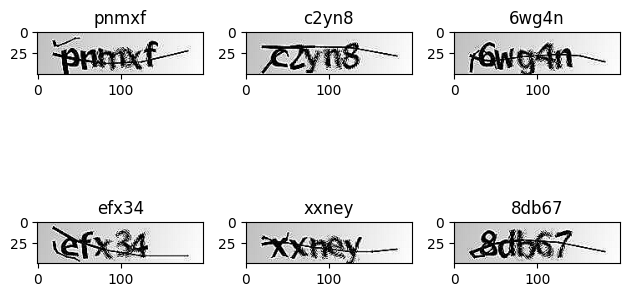

In [117]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_index in range(0, 6, 1):
    # print(img_paths[img_index].shape)
    image = cv2.imread(img_paths_with_base_dir[img_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if img_index % 3 == 0 and img_index != 0:
        row += 1
    axes[row, img_index % num_cols].imshow(image)
    axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

## Removing Blur and Sharpening the Images

As per the dataset, the provided images have noise/blur added to them. Before passing our captcha images to the models, let us denoise them.

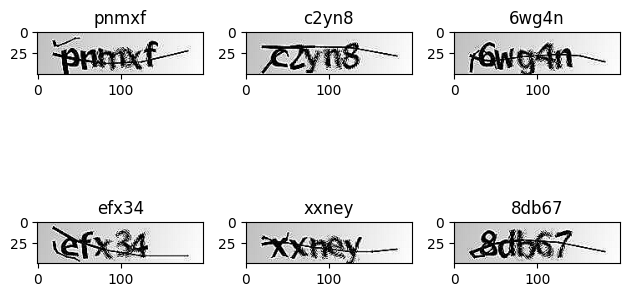

In [100]:
# References
# https://www.analyticsvidhya.com/blog/2021/08/sharpening-an-image-using-opencv-library-in-python/
# https://stackoverflow.com/questions/58231849/how-to-remove-blurriness-from-an-image-using-opencv-python-c

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_index in range(0, 6, 1):
    # print(img_paths[img_index].shape)
    image = cv2.imread(img_paths_with_base_dir[img_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(image, -1, sharpen_kernel)

    if img_index % 3 == 0 and img_index != 0:
        row += 1
    axes[row, img_index % num_cols].imshow(sharpened_image)
    axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

The sharpening appears to be definitely reducing blur. Let us apply this transformation to our entire dataset.

First, we apply this filter to images within `datadir`.

In [104]:
num_images = len(os.listdir(datadir))

for img_index in range(5, num_images - 1, 1):
  # img_path = datadir + "/" + img_paths[img_index]
  if (".png" in img_paths_with_base_dir[img_index]) or (".jpg" in img_paths[img_index]):
    image = cv2.imread(img_paths_with_base_dir[img_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(image, -1, sharpen_kernel)
    # plt.imshow(sharpened_image)
    # plt.show()
    cv2.imwrite(img_paths[img_index], sharpened_image)

Now, we apply the filter to images in the `samples` directory.

In [106]:
samples_img_paths = os.listdir(datadir + "/samples")
num_images = len(samples_img_paths)

for img_index in range(num_images):
  image = cv2.imread(datadir + "/samples/" + samples_img_paths[img_index])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
  sharpened_image = cv2.filter2D(image, -1, sharpen_kernel)

  # plt.imshow(sharpened_image)
  # plt.show()
  cv2.imwrite(datadir + "/samples/" + samples_img_paths[img_index], sharpened_image)

## Building the Dataloader

In [123]:
base_dir_dataset = list(zip(img_paths_with_base_dir, captcha_labels_train))
base_dir_dataset = pd.DataFrame(base_dir_dataset, columns=["img_path", "label"])
base_dir_dataset.head()

,img_path,label
0,/content/drive/My Drive/captcha-images/pnmxf.png,pnmxf
1,/content/drive/My Drive/captcha-images/c2yn8.png,c2yn8
2,/content/drive/My Drive/captcha-images/6wg4n.png,6wg4n
3,/content/drive/My Drive/captcha-images/efx34.png,efx34
4,/content/drive/My Drive/captcha-images/xxney.png,xxney


The above are image files from the root directory. We will use these for training. Later in the notebook, we will train further on data from `samples`.

In [124]:
class CaptchaDataset(Dataset):
    def __init__(self, image_annotations: pd.DataFrame, data_dir: str, transform=None, target_transform=None):
        self.img_annotations = image_annotations
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, sample_idx):
        img_path = self.img_annotations["img_path"][sample_idx]
        image = cv2.imread(img_path)
        label = self.img_annotations["label"][sample_idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [129]:
datadir = "/content/drive/My Drive/captcha-images"

training_data_round_one = base_dir_dataset.sample(frac=0.8)
test_data_round_one = base_dir_dataset.drop(training_data_round_one.index)

training_data_round_one = CaptchaDataset(training_data_round_one, datadir)
test_data_round_one = CaptchaDataset(test_data_round_one, datadir)

train_loader = DataLoader(training_data_round_one, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_round_one, batch_size=32, shuffle=True)